# Sense Embed

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, os
sys.path.append("../")

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from flair.embeddings import Sentence, BertEmbeddings
from tqdm import tqdm_notebook as tqdm

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
from CwnGraph import CwnBase, CwnSense
from GWA2019 import cwn_sense_utils as utils

In [5]:
cwn = CwnBase()

In [6]:
HYPER_ANNOT_DATA_PATH = "../data/merged_checked.csv"
if not os.path.exists(HYPER_ANNOT_DATA_PATH):
    raise FileNotFoundError(HYPER_ANNOT_DATA_PATH, "not found")

In [7]:
hyper_annot_data = pd.read_csv(HYPER_ANNOT_DATA_PATH)
hyper_annot_data.head()

,lemma,c1,c2,statement,response
0,一些,一,些,一些 是一種 些,0
1,一半,一,半,一半 是一種 半,0
2,一如,一,如,一如 是一種 如,0
3,一定,一,定,一定 是一種 定,1
4,一律,一,律,一律 是一種 律,0


## play around with hyper_annot_data

In [8]:
hyper_annot_data.head()

,lemma,c1,c2,statement,response
0,一些,一,些,一些 是一種 些,0
1,一半,一,半,一半 是一種 半,0
2,一如,一,如,一如 是一種 如,0
3,一定,一,定,一定 是一種 定,1
4,一律,一,律,一律 是一種 律,0


In [9]:
def group_cx_data(frame, cidx):
    cx_frame = frame[[cidx, "response"]] \
                    .groupby([cidx]).agg(['count', 'mean'])
    cx_frame.columns = cx_frame.columns.droplevel(0)
    cx_frame.sort_values(["count", "mean"], ascending=False, inplace=True)    
    cx_frame.rename_axis("charac", inplace=True)
    return cx_frame
hyper_c1_data = group_cx_data(hyper_annot_data, "c1")
hyper_c2_data = group_cx_data(hyper_annot_data, "c2")

In [10]:
hyper_c1_data.head()
hyper_c2_data.head()
char_data = hyper_c1_data.merge(hyper_c2_data, on="charac", suffixes=("_c1", "_c2"))

In [14]:
char_data.head(10)

,count_c1,mean_c1,count_c2,mean_c2
charac,,,,
大,21,0.523810,8,0.125000
分,16,0.062500,5,0.400000
有,15,0.266667,11,0.454545
人,14,0.428571,25,0.720000
為,14,0.285714,15,0.266667
相,12,0.500000,2,0.500000
發,12,0.416667,6,0.666667
自,12,0.416667,3,0.333333
一,12,0.333333,4,0.000000


In [15]:
char_data.sort_values("count_c2", ascending=False).head(10)

,count_c1,mean_c1,count_c2,mean_c2
charac,,,,
子,3,0.666667,27,0.037037
人,14,0.428571,25,0.720000
出,9,0.666667,19,0.210526
到,2,0.000000,18,0.111111
生,8,0.375000,16,0.187500
心,6,0.000000,16,0.125000
為,14,0.285714,15,0.266667
得,2,0.000000,15,0.133333
意,9,0.555556,15,0.066667


In [16]:
char_data.to_csv("../data/char_data_merged.csv")

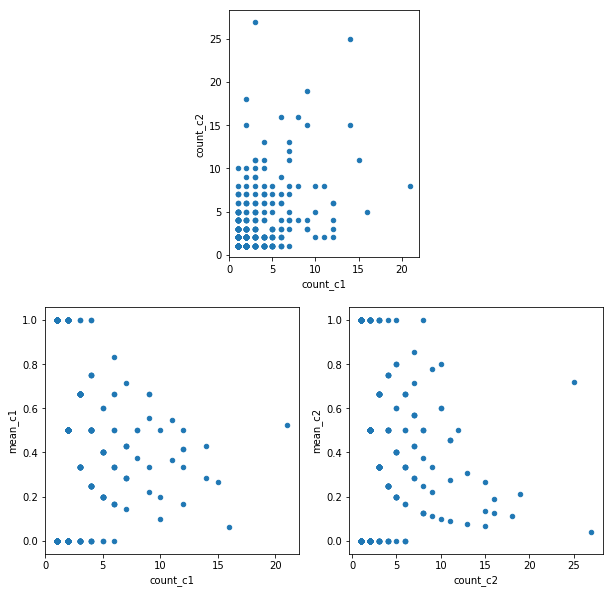

In [17]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax1.set_aspect('equal')
char_data.plot("count_c1", "count_c2", 'scatter', ax=ax1)
ax2 = plt.subplot2grid((2,2), (1,0))
char_data.plot("count_c1", "mean_c1", 'scatter', ax=ax2)
ax3 = plt.subplot2grid((2,2), (1,1))
char_data.plot("count_c2", "mean_c2", 'scatter', ax=ax3)

# Sense Embed

## Eye-balling incoming lemmas

In [18]:
all_lemmas = set(hyper_annot_data.lemma.tolist()) \
                .union(hyper_annot_data.c1.tolist()) \
                .union(hyper_annot_data.c2.tolist())

In [19]:
cwn_senses = [CwnSense(nid, cwn) for nid, ndata in cwn.V.items() if ndata["node_type"] == "sense"]

In [20]:
len(cwn_senses)

28827

In [21]:
all_senses = []
for sense_x in cwn_senses:
    if any([lem_x.lemma in all_lemmas for lem_x in sense_x.lemmas]):
        all_senses.append(sense_x)
all_examples = [len(x.all_examples()) for x in all_senses]

In [22]:
# a brief summary of all_lemmas
print("total lemmas: {}".format(len(all_lemmas)))
print("two-character lemmas: {}".format(sum([1 for x in all_lemmas if len(x)==2])))
print("one-character lemmas: {}".format(sum([1 for x in all_lemmas if len(x)==1])))
print("senses in lemmas: {}".format(len(all_senses)))
print("examples in lemmas: {}".format(sum(all_examples)))

total lemmas: 2897
two-character lemmas: 1815
one-character lemmas: 1082
senses in lemmas: 11521
examples in lemmas: 37976


In [23]:
# print a 10% sample of all_lemmas, just for inspection
import random
print([x for x in all_lemmas if random.random() < 0.1])

['頂嘴', '核定', '歡暢', '鳳', '秋', '恐', '這', '遺址', '申訴', '慢慢', '我國', '喜歡', '底', '摸', '女兒', '頒給', '花園', '飯', '掉', '力', '盼', '辦法', '政', '縣', '古典', '整整', '國寶', '沒有', '近', '名氣', '整', '精', '線', '遇', '觸', '弱', '大早', '惡化', '憂悶', '不忠', '他', '美國', '武松', '工會', '析', '優勢', '連線', '便', '搖', '手法', '義', '面積', '累積', '早晨', '鼓勵', '思念', '那邊', '畏懼', '紐', '答覆', '毛', '單純', '懶得', '心醉', '陽', '記過', '廳', '區', '婦女', '別', '申', '觀音', '稱為', '諸', '交', '授予', '生存', '捐出', '古', '指出', '湯匙', '專門', '租', '溪', '遠大', '漂', '叉', '寄給', '可見', '注意', '國小', '簡稱', '從業', '劇', '舊', '開戰', '政大', '角色', '電路', '依賴', '工程', '揮', '聖火', '妙', '反感', '頒獎', '個人', '有志', '載明', '苦', '論', '遊', '推動', '社', '化', '調', '允許', '染色', '碰', '堅持', '協助', '蘭嶼', '演', '官員', '編', '宏', '藥物', '凍原', '鬆', '指', '岸', '解決', '光電', '保守', '分隔', '意外', '苔原', '攤', '筆', '崩解', '相較', '亞', '怨', '脈', '糕點', '發掘', '國防', '定值', '畢業', '兔子', '誘', '本錢', '開花', '聲浪', '休息', '小', '找到', '轟炸', '氣憤', '春', '容易', '賜給', '排行', '爽', '顧客', '烏龜', '肯定', '周', '故意', '滿意', '東南', '火力', '孟', '氣', '來信', '超越', '制', '造勢',

## compute sense-embedding

In [24]:
bert = BertEmbeddings('bert-base-chinese', layers='-1,-2,-3,-4', pooling_operation='mean')

In [25]:
sense_embed = {}

In [26]:
# load sense_embed cache
SENSE_EMBED_PATH = "../data/sense_embed.pkl"
if os.path.exists(SENSE_EMBED_PATH):
    with open(SENSE_EMBED_PATH, "rb") as fin:
        sense_embed = pickle.load(fin)
    RUN_EMBED = False
else:
    print("Cannot find ", SENSE_EMBED_PATH)
    RUN_EMBED = True

In [27]:
# this block took ~1 hour in an i7 desktop, resulting pickle is around 1.6G
if RUN_EMBED:
    counter = 0

    for sense_x in tqdm(all_senses):
        examples = sense_x.all_examples()
        for ex_i, ex_x in enumerate(examples):
            examples[ex_i] = ex_x.replace("〈", "<").replace("〉", ">")
        if not examples:
            print(f"skipping {sense_x} with no examples")
            continue
        try:
            sense_data = utils.compute_sense_data({sense_x.id: examples}, bert)
            sense_embed[sense_x.id] = sense_data
        except Exception as ex:
            print(f"[{sense_x}]: {ex}")

        if counter % 1000 == 0:
            with open(SENSE_EMBED_PATH, "wb") as fout:
                pickle.dump(sense_embed, fout)
        counter += 1

    with open(SENSE_EMBED_PATH, "wb") as fout:
        pickle.dump(sense_embed, fout)

In [28]:
# resulting sense embed object, 7 embeddings are failed to construct embeddings, due to no valid examples

In [29]:
len(sense_embed)

11514

# Sense simulation study

In [30]:
from GWA2019 import make_sense_utils as senseutils

In [31]:
PERM_SIMULATION_PATH = "../data/gwa2019_simulation_results.pkl"
perm_simulations = {}
try:
    with open(PERM_SIMULATION_PATH, "rb") as fin:
        perm_simulations = pickle.load(fin)
        RUN_PERM = False
except Exception as ex:
    print(ex)
    RUN_PERM = True

In [32]:
# this block took ~2minute in a i7 desktop
if RUN_PERM:
    for lemma_x in tqdm(all_lemmas):
        try:
            perm_result = senseutils.run_simulation(lemma_x, cwn, sense_embed)
            perm_simulations[lemma_x] = perm_result
        except Exception as ex:
            print(f"[{lemma_x}]: {ex}")

    with open(PERM_SIMULATION_PATH, "wb") as fout:
        pickle.dump(perm_simulations, fout)

### number of lemmas that only have a single sense
therefore they cannot compute a valid F-statistics

In [33]:
single_sense_stat = [x for _, x in perm_simulations.items() if np.isnan(x.senses.stat)]
print(len(single_sense_stat))

830


### histogram

In [34]:
sense_pval = []
perm_pval = []
rand_pval = []
for lemma_x, sim_x in perm_simulations.items():
    if np.isnan(sim_x.senses.stat):
        continue
    sense_pval.append(sim_x.senses.pval)
    perm_pval.append(sim_x.permutation.pval)
    rand_pval.append(sim_x.random.pval)

In [35]:
np.quantile(sense_pval, [.025, .975])

array([0.00240169, 0.35021109])

In [36]:
def report_stat_pval(pval_vec):
    qs = np.quantile(pval_vec, [.025, .975])
    print(f"M = {np.mean(pval_vec):.2f}, SD = {np.std(pval_vec):.2f}, Q[.025]={qs[0]:.4f}, Q[.975]={qs[1]:.4f}")
report_stat_pval(sense_pval)
report_stat_pval(perm_pval)
report_stat_pval(rand_pval)

M = 0.14, SD = 0.10, Q[.025]=0.0024, Q[.975]=0.3502
M = 0.42, SD = 0.09, Q[.025]=0.2285, Q[.975]=0.5780
M = 0.41, SD = 0.05, Q[.025]=0.3200, Q[.975]=0.4814


### t-test between original sense and permutations

the t-test compares the means under sense and permutation condition. Although the distribution of sense condition is not gaussian, but the mean of the distribution should be from a normal sampling distribution of sample mean, according to central limit theorem. Likewise, the mean from permutation condition should also comes from a gaussian distribution. A more conservative independent t-test is used here, although each lemma go through both sense condition and permutation condition. The overall effect is highly significant, which may be the results from the large effect, and large degree of freedom.

In [37]:
from scipy.stats import ttest_ind
tstat = ttest_ind(sense_pval, perm_pval)
df = (len(sense_pval)-1)*2
print(f"t({df}) = {tstat.statistic:.2f}, p < {tstat.pvalue:.4f}")

t(4128) = -93.63, p < 0.0000


(-0.1, 0.8)

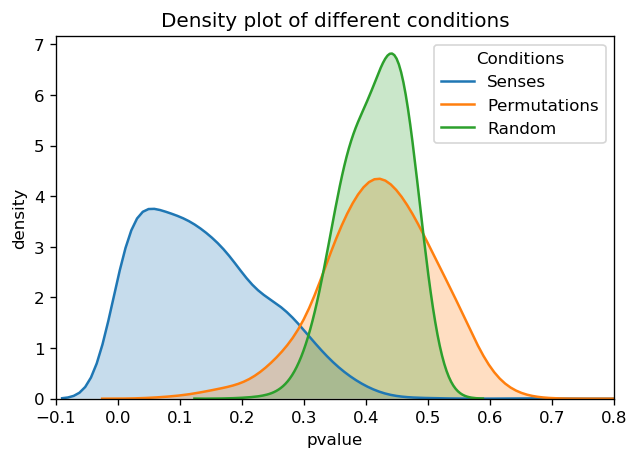

In [47]:
BW = 0.03
plt.figure(figsize=(6,4), dpi=120)
sns.distplot(sense_pval, hist=False, kde=True, kde_kws={'shade': True, "bw": BW}, label="Senses")
sns.distplot(perm_pval, hist=False, kde=True, kde_kws={'shade': True, "bw": BW}, label="Permutations")
sns.distplot(rand_pval, hist=False, kde=True, kde_kws={'shade': True, "bw": BW}, label="Random")
plt.legend(title='Conditions')
plt.title("Density plot of different conditions")
plt.ylabel('density')
plt.xlabel('pvalue')
plt.xlim(-0.1,0.8)

# Link Senses

In [48]:
SENSE_LINK_PATH = "../data/sense_link_data.pkl"
sense_link_data = []
try:
    with open(SENSE_LINK_PATH, "rb") as fin:
        sense_link_data = pickle.load(fin)
    RUN_LINKSENSE = False
except Exception as ex:
    print(ex)
    RUN_LINKSENSE = True

[Errno 2] No such file or directory: '../data/sense_link_data.pkl'


In [49]:
# this block took ~70 seconds in a i7-desktop
if RUN_LINKSENSE:
    for idx, row in tqdm(hyper_annot_data.iterrows()):
        try:
            links = senseutils.link_senses(row.lemma, row.c2, cwn, sense_embed, n=10)
            (best_1, best_2), score = links[0]        
            sense_link_data.append((row.lemma, best_1.id, best_1.definition, best_2.id, best_2.definition))    
        except Exception as ex:
            print(f"[{row.lemma}]: {ex}")
    with open(SENSE_LINK_PATH, "wb") as fout:
        pickle.dump(sense_link_data, fout)

[憂悶]: expected a non-empty list of Tensors
[憂愁]: expected a non-empty list of Tensors



In [50]:
sense_link_frame = pd.DataFrame.from_records(sense_link_data, 
                columns=["lemma", "cwn_id_1", "sense_def_1", "cwn_id_2", "sense_def_2"])

In [51]:
sense_link_frame.set_index("lemma", inplace=True)
base_frame = hyper_annot_data.set_index("lemma")

In [52]:
sense_pair_merged = base_frame.merge(sense_link_frame, left_index=True, right_index=True)
sense_pair_merged.to_csv("../data/sense_pair_merged.csv")

In [53]:
sense_pair_merged.head()

,c1,c2,statement,response,cwn_id_1,sense_def_1,cwn_id_2,sense_def_2
lemma,,,,,,,,
一些,一,些,一些 是一種 些,0,05052702,表程度輕微，常接在形容詞之後。,04045802,表程度輕微，常接在形容詞之後。
一半,一,半,一半 是一種 半,0,03048901,二分之一。,04081901,整體的二分之一。
一如,一,如,一如 是一種 如,0,03049701,引介與前述事物有高相似度的後述事物作為譬喻。,03036505,表譬喻事件情況。
一定,一,定,一定 是一種 定,1,05052501,表對推論的肯定，沒有例外。,09254101,表對推論的肯定，沒有例外。
一律,一,律,一律 是一種 律,0,04032901,表後述的條件適用全體，沒有例外。,09047003,由立法機關制定，有強制效力的行為規範。
